In [1]:
import sys
import os

notebook_path = os.getcwd() 
project_root = os.path.dirname(notebook_path)

if project_root not in sys.path:
    sys.path.insert(0, project_root)

os.mkdir("models_sanity_check") if not os.path.exists("models_sanity_check") else None
model_storage_path = os.path.join(project_root, "testcases/models_sanity_check")

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [3]:
import NN_models
import Filters
import utils
import Systems
from torch.utils.data import TensorDataset, DataLoader, random_split
from state_NN_models.StateKalmanNet import StateKalmanNet
from state_NN_models.StateKalmanNetWithKnownR import StateKalmanNetWithKnownR
from state_NN_models.StateBayesianKalmanNet import StateBayesianKalmanNet

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Používané zařízení: {device}")

Používané zařízení: cuda


In [5]:
state_dim = 1
obs_dim = 1

# --- Reálný systém ("Ground Truth") ---
F_true = torch.tensor([[0.2]])
H_true = torch.tensor([[1.0]])
Q_true = torch.tensor([[0.5]])
R_true = torch.tensor([[0.1]])
Ex0_true = torch.tensor([[1.0]])  # Střední hodnota počátečního stavu
P0_true = torch.tensor([[1.5]])   # Počáteční kovariance

# --- Model systému ---
F_model = torch.tensor([[0.7]])
H_model = H_true
Q_model = torch.tensor([[0.1]]) 
R_model = R_true
Ex0_model = torch.tensor([[0.5]])  # Schválně jiná střední hodnota
P0_model = torch.tensor([[1.0]])   # Schválně jiná počáteční kovariance

# h_true_nonlinear = lambda x: 0.5 * x
# f_true_nonlinear = lambda x: 0.9 * x - 0.05 * x**3 

# Q_true = torch.tensor([[0.1]])
# R_true = torch.tensor([[0.1]])

# Ex0_true = torch.tensor([[1.0]])
# P0_true = torch.tensor([[0.5]])

# #  Nepřesná dynamika (lineární aproximace nelineární funkce f)
# f_model_nonlinear = lambda x: 0.9 * x 
# h_model_nonlinear = h_true_nonlinear
# # Nepřesná znalost šumu (podcenění Q)
# Q_model = torch.tensor([[0.01]])
# R_model = torch.tensor([[0.2]])
# # Nepřesný počáteční odhad (pro EKF)
# Ex0_model = torch.tensor([[0.5]])
# P0_model = torch.tensor([[0.5]])


sys_true = Systems.DynamicSystem(
    state_dim=state_dim,
    obs_dim=obs_dim,
    Ex0=Ex0_true,
    P0=P0_true,
    Q=Q_true,
    R=R_true,
    F=F_true,
    H=H_true,
    device=device
)

sys_model = Systems.DynamicSystem(
    state_dim=state_dim,
    obs_dim=obs_dim,
    Ex0=Ex0_model,
    P0=P0_model,
    Q=Q_model,
    R=R_model,
    F=F_model,
    H=H_model,
    device=device
)

# print("\nInicializace systémů dokončena.")
# print(f"Reálný systém: f(x) = {sys_true.F.item():.2f}*x, h(x) = {sys_true.H.item():.2f}*x")
# print(f"Model systému: f(x) = {sys_model.F.item():.2f}*x, h(x) = {sys_model.H.item():.2f}*x")

In [6]:
TRAIN_SEQ_LEN = 10      # Krátké sekvence pro stabilní trénink (TBPTT)
VALID_SEQ_LEN = 20      # Stejná délka pro konzistentní validaci
TEST_SEQ_LEN = 200      # Dlouhé sekvence pro testování generalizace

NUM_TRAIN_TRAJ = 500   # Hodně trénovacích příkladů
NUM_VALID_TRAJ = 50    # Dostatek pro spolehlivou validaci
NUM_TEST_TRAJ = 100     # Pro robustní vyhodnocení

BATCH_SIZE = 5         # Dobrý kompromis

x_train, y_train = utils.generate_data(sys_true, num_trajectories=NUM_TRAIN_TRAJ, seq_len=TRAIN_SEQ_LEN)
x_val, y_val = utils.generate_data(sys_true, num_trajectories=NUM_VALID_TRAJ, seq_len=VALID_SEQ_LEN)
x_test, y_test = utils.generate_data(sys_true, num_trajectories=1, seq_len=TEST_SEQ_LEN)

train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [7]:
kalman_filter = Filters.ExtendedKalmanFilter(sys_model)
y_first_trajectory = y_test[0] 
x_true_first_trajectory = x_test[0]

kf_results = kalman_filter.process_sequence(y_first_trajectory)

x_hat_kf = kf_results['x_filtered']
P_hat_kf = kf_results['P_filtered']

print("\nZpracování dokončeno.")
print(f"Tvar odhadnutých stavů: {x_hat_kf.shape}")
print(f"Tvar skutečných stavů:  {x_true_first_trajectory.shape}")

mse_kf = torch.nn.functional.mse_loss(x_hat_kf, x_true_first_trajectory)
print(f"MSE pro EKF na první trajektorii: {mse_kf.item():.4f}")


Zpracování dokončeno.
Tvar odhadnutých stavů: torch.Size([200, 1])
Tvar skutečných stavů:  torch.Size([200, 1])
MSE pro EKF na první trajektorii: 0.1453


In [8]:
adaptive_kalman_filter = Filters.AdaptiveExtendedKalmanFilter(sys_model,sys_model.Q,sys_model.R,alpha=0.1)
y_first_trajectory = y_test[0] 
x_true_first_trajectory = x_test[0]

adaptive_kf_results = adaptive_kalman_filter.process_sequence(y_first_trajectory)

x_hat_aekf = adaptive_kf_results['x_filtered']
P_hat_aekf = adaptive_kf_results['P_filtered']

print("\nZpracování dokončeno.")
print(f"Tvar odhadnutých stavů: {x_hat_aekf.shape}")
print(f"Tvar skutečných stavů:  {x_true_first_trajectory.shape}")

mse_aekf = torch.nn.functional.mse_loss(x_hat_aekf, x_true_first_trajectory)
print(f"MSE pro AEKF na první trajektorii: {mse_aekf.item():.4f}")




Zpracování dokončeno.
Tvar odhadnutých stavů: torch.Size([200, 1])
Tvar skutečných stavů:  torch.Size([200, 1])
MSE pro AEKF na první trajektorii: 0.4971


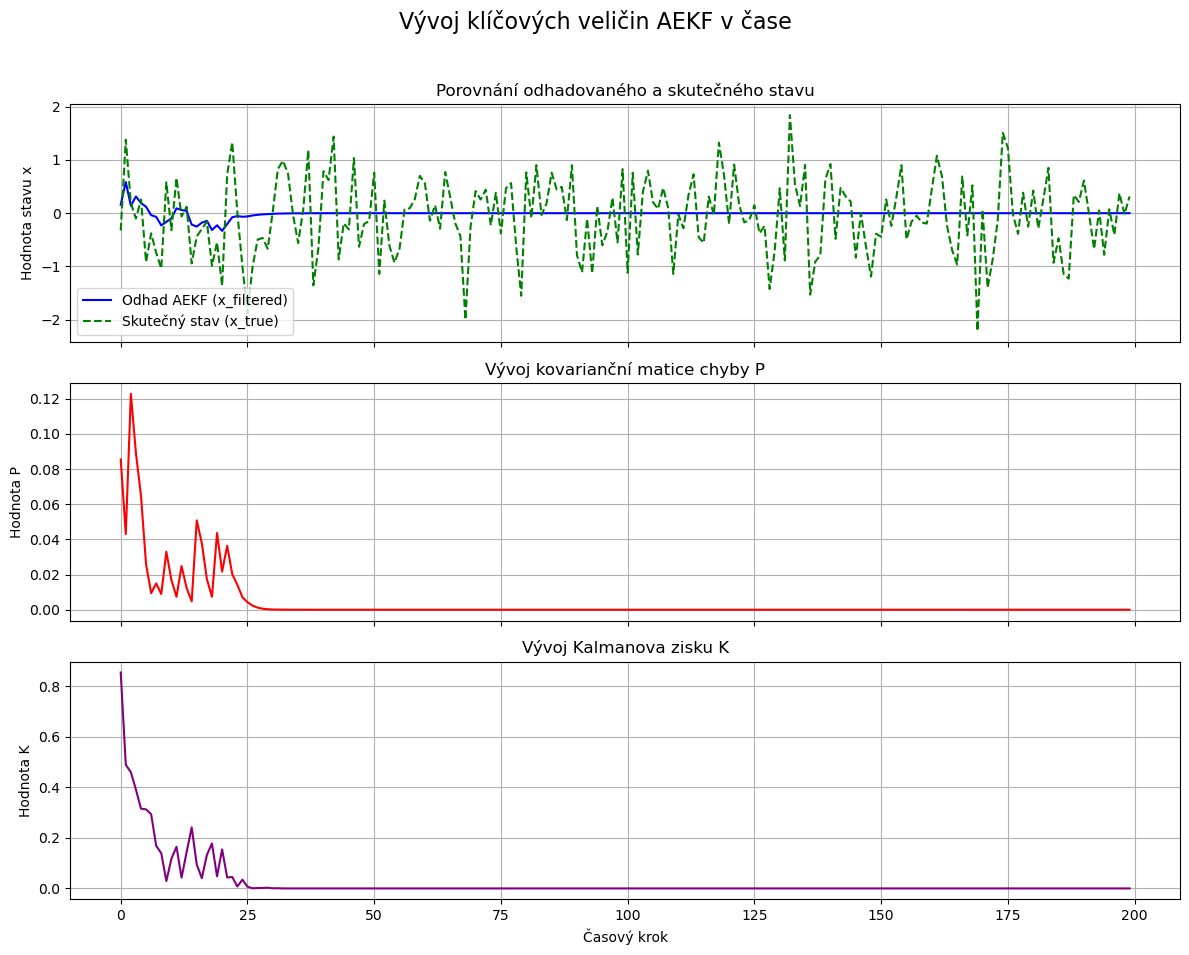

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# --- Získání dat z výsledků filtru ---
x_hat_aekf = adaptive_kf_results['x_filtered']
P_hat_aekf = adaptive_kf_results['P_filtered']
K_aekf = adaptive_kf_results['Kalman_gain']

# Počet časových kroků
TEST_SEQ_LEN = x_hat_aekf.shape[0]
time = np.arange(TEST_SEQ_LEN)

# Převod tenzorů na NumPy pro plotování (a odstranění přebytečných dimenzí)
x_hat_aekf_numpy = x_hat_aekf.detach().cpu().numpy().squeeze()
x_true_numpy = x_true_first_trajectory.detach().cpu().numpy().squeeze()
P_hat_aekf_numpy = P_hat_aekf.detach().cpu().numpy().squeeze()
K_aekf_numpy = K_aekf.detach().cpu().numpy().squeeze()


# --- Vytvoření grafů ---
fig, ax = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
fig.suptitle('Vývoj klíčových veličin AEKF v čase', fontsize=16)

# 1. Graf: Odhadovaný a skutečný stav (x_filtered)
ax[0].plot(time, x_hat_aekf_numpy, label='Odhad AEKF (x_filtered)', color='blue')
ax[0].plot(time, x_true_numpy, label='Skutečný stav (x_true)', color='green', linestyle='--')
ax[0].set_title('Porovnání odhadovaného a skutečného stavu')
ax[0].set_ylabel('Hodnota stavu x')
ax[0].legend()
ax[0].grid(True)

# 2. Graf: Kovariance chyby (P_filtered)
ax[1].plot(time, P_hat_aekf_numpy, label='Kovariance chyby (P_filtered)', color='red')
ax[1].set_title('Vývoj kovarianční matice chyby P')
ax[1].set_ylabel('Hodnota P')
ax[1].grid(True)
# Pro lepší vizualizaci kolapsu můžete zkusit logaritmickou škálu:
# ax[1].set_yscale('log')

# 3. Graf: Kalmanův zisk (K)
ax[2].plot(time, K_aekf_numpy, label='Kalmanův zisk (K)', color='purple')
ax[2].set_title('Vývoj Kalmanova zisku K')
ax[2].set_ylabel('Hodnota K')
ax[2].set_xlabel('Časový krok')
ax[2].grid(True)

# Zobrazit grafy
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

In [11]:

state_bkn_knet = StateBayesianKalmanNet(sys_model, device=device, hidden_size_multiplier=3, output_layer_multiplier=2, num_gru_layers=1, init_min_dropout=0.3, init_max_dropout=0.5).to(device)
trained_model = utils.train_bkn_reference_replication(
    model=state_bkn_knet,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    total_train_iter=600,
    learning_rate=1e-3, # Autoři používají jednu konstantní LR
    clip_grad=10.0,
    J_samples=20,
    validation_period=50,
    logging_period=25,
    final_beta=0.9 # Maximální hodnota bety
)


--- Iterace [25/600] ---
--- Loss Stats (Replikace autorů) ---
  Total Loss:   1.121329 | Current Beta: 0.0360
    ├─ L1 (MSE):   0.433557
    ├─ L2 (Var MAE) sum :0.433429 (váha: beta * SUM)
    └─ Regularize: 0.000027 (váha: SUM)
--- Variance Stats ---
  Predicted Var -> Avg: 0.000128, Min: 0.000000, Max: 0.002057
  True Var      -> Avg: 0.433557, Min: 0.000279, Max: 2.198751
--- Gradient Stats ---
  Total Grad Norm (before clipping): 2.430078
--- Model Stats ---
  Learned p: p1=0.4351, p2=0.3913

--- Iterace [50/600] ---
--- Loss Stats (Replikace autorů) ---
  Total Loss:   1.268093 | Current Beta: 0.0735
    ├─ L1 (MSE):   0.304096
    ├─ L2 (Var MAE) sum :0.297850 (váha: beta * SUM)
    └─ Regularize: 0.000027 (váha: SUM)
--- Variance Stats ---
  Predicted Var -> Avg: 0.006283, Min: 0.000004, Max: 0.099178
  True Var      -> Avg: 0.304096, Min: 0.001491, Max: 1.118287
--- Gradient Stats ---
  Total Grad Norm (before clipping): 3.358565
--- Model Stats ---
  Learned p: p1=0.4337, 

KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np

# ==============================================================================
# Předpoklady... (zůstávají stejné)
# ==============================================================================


# --- 1. Definice pomocných funkcí a metrik ---

def calculate_anees(x_true_list, x_hat_list, P_hat_list):
    """
    Vypočítá Average NEES (ANEES) ze seznamů trajektorií.
    Tato funkce nyní explicitně očekává všechny tenzory na CPU.
    """
    num_runs = len(x_true_list)
    if num_runs == 0:
        return 0.0
        
    total_nees = 0.0
    for i in range(num_runs):
        # Ujistíme se, že vše je na CPU, pro případ, že by se něco pokazilo
        x_true = x_true_list[i].cpu()
        x_hat = x_hat_list[i].cpu()
        P_hat = P_hat_list[i].cpu()
        
        # Přeskakujeme počáteční stav t=0, protože jeho chyba je 0 a P0 je často umělé
        seq_len = x_true.shape[0] - 1
        state_dim = x_true.shape[1]
        nees_samples_run = torch.zeros(seq_len)

        for t in range(seq_len):
            # Posuneme index o 1, abychom začali od t=1
            error = x_true[t+1] - x_hat[t+1]
            P_t = P_hat[t+1] # Kovariance pro odhad v čase t+1
            
            # P_t už má správný tvar [state_dim, state_dim] z výpočtu níže
            
            # Stabilizace pro případ, že by matice byla singulární
            P_stable = P_t + torch.eye(state_dim, device=P_t.device) * 1e-9
            
            try:
                P_inv = torch.inverse(P_stable)
                nees_samples_run[t] = error.unsqueeze(0) @ P_inv @ error.unsqueeze(-1)
            except torch.linalg.LinAlgError:
                print(f"Varování: Singularita matice P v trajektorii {i}, kroku {t+1}. Přeskakuji.")
                nees_samples_run[t] = float('nan')
            
        total_nees += torch.nanmean(nees_samples_run).item()
        print(f"Trajektorie {i+1}/{num_runs}, ANEES: {torch.nanmean(nees_samples_run).item():.4f}")
    return total_nees / num_runs

# --- 2. Příprava a generování dat ---

TEST_SEQ_LEN = 200
NUM_TEST_TRAJ = 10
J_SAMPLES_TEST = 20

print(f"Generuji {NUM_TEST_TRAJ} testovacích trajektorií...")
# Předpokládáme, že generate_data vrací tenzory na CPU
x_test, y_test = utils.generate_data(sys_true, num_trajectories=NUM_TEST_TRAJ, seq_len=TEST_SEQ_LEN)

# --- 3. Vyhodnocovací smyčka ---

# Přepneme model do evaluačního módu (vypne dropout atd.)
state_bkn_knet.eval()

# Seznamy pro sběr výsledků, explicitně určené pro CPU
all_x_true_cpu, all_x_hat_knet_cpu, all_P_hat_knet_cpu = [], [], []
# ... (pokud byste chtěl EKF, tak i pro něj)

print(f"Vyhodnocuji na {NUM_TEST_TRAJ} testovacích trajektoriích...")

with torch.no_grad():
    for i in range(NUM_TEST_TRAJ):
        y_test_seq = y_test[i]
        x_true_seq = x_test[i]
        
        # --- Vyhodnocení vaší StateBayesianKalmanNet ---
        
        # Přesun dat na GPU těsně před použitím v modelu
        y_test_seq_gpu = y_test_seq.to(device)
        x_true_seq_gpu = x_true_seq.to(device)
        
        initial_state_gpu = x_true_seq_gpu[0, :].unsqueeze(0) # Tvar [1, state_dim]
        state_bkn_knet.reset(batch_size=1, num_samples=J_SAMPLES_TEST, initial_state=initial_state_gpu)
        
        knet_predictions_gpu = []
        knet_covariances_gpu = []
        
        # Iterujeme od t=1, protože stav v t=0 je daný
        for t in range(1, TEST_SEQ_LEN):
            y_t_gpu = y_test_seq_gpu[t, :].unsqueeze(0) # Tvar [1, obs_dim]
            x_ensemble_t, _ = state_bkn_knet.step(y_t_gpu, num_samples=J_SAMPLES_TEST) # Vrací [J, 1, state_dim]
            
            # Výpočet průměru a kovariance
            x_filtered_t = x_ensemble_t.mean(dim=0) # Tvar [1, state_dim]
            diff = x_ensemble_t - x_filtered_t # Broadcasting [J, 1, D] - [1, 1, D] -> [J, 1, D]
            
            # Výpočet vnějšího součinu a průměrování
            # diff.unsqueeze(-1) -> [J, 1, D, 1]
            # diff.unsqueeze(-2) -> [J, 1, 1, D]
            # Výsledek násobení je [J, 1, D, D], po průměru [1, D, D]
            P_filtered_t = (diff.unsqueeze(-1) @ diff.transpose(-1, -2)).mean(dim=0)
            
            knet_predictions_gpu.append(x_filtered_t)
            knet_covariances_gpu.append(P_filtered_t)
            
        # Spojení výsledků ze sekvence
        x_hat_knet_seq_gpu = torch.cat(knet_predictions_gpu, dim=0) # Tvar [seq-1, state_dim]
        P_hat_knet_seq_gpu = torch.cat(knet_covariances_gpu, dim=0) # Tvar [seq-1, state_dim, state_dim]
        
        # Přidání počátečního stavu a kovariance pro kompletní trajektorii
        x_hat_knet_full_gpu = torch.cat([initial_state_gpu, x_hat_knet_seq_gpu], dim=0)
        
        # Počáteční kovariance P0 by měla být malá, ale ne nulová
        P0_knet_gpu = sys_true.P0.unsqueeze(0).to(device)
        P_hat_knet_full_gpu = torch.cat([P0_knet_gpu, P_hat_knet_seq_gpu], dim=0)
        
        # Přesun finálních výsledků na CPU a uložení
        all_x_true_cpu.append(x_true_seq.cpu())
        all_x_hat_knet_cpu.append(x_hat_knet_full_gpu.cpu())
        all_P_hat_knet_cpu.append(P_hat_knet_full_gpu.cpu())
        
        if (i + 1) % 1 == 0:
            print(f"Dokončeno {i + 1}/{NUM_TEST_TRAJ} běhů...")

# --- 4. Finální výpočet průměrných metrik ---
# Všechny tenzory jsou nyní bezpečně na CPU
x_true_all = torch.cat(all_x_true_cpu)
x_hat_knet_all = torch.cat(all_x_hat_knet_cpu)

avg_mse_knet = F.mse_loss(x_hat_knet_all, x_true_all).item()

anees_knet = calculate_anees(all_x_true_cpu, all_x_hat_knet_cpu, all_P_hat_knet_cpu)

# --- 5. Finální výpis ---
state_dim_for_nees = all_x_true_cpu[0].shape[1]

print("\n" + "="*50)
print(f"FINÁLNÍ VÝSLEDKY (průměr přes {NUM_TEST_TRAJ} běhů)")
print("="*50)
print("\n--- Průměrná MSE (přesnost) ---")
print(f"Bayesian KNet:    {avg_mse_knet:.4f}")
print("\n--- Průměrný ANEES (kredibilita/kalibrace) ---")
print(f"Očekávaná hodnota: {state_dim_for_nees:.4f}")
print("---------------------------------------")
print(f"Bayesian KNet:    {anees_knet:.4f}")
print("="*50)

Generuji 10 testovacích trajektorií...
Vyhodnocuji na 10 testovacích trajektoriích...
Dokončeno 1/10 běhů...
Dokončeno 2/10 běhů...
Dokončeno 3/10 běhů...
Dokončeno 4/10 běhů...
Dokončeno 5/10 běhů...
Dokončeno 6/10 běhů...
Dokončeno 7/10 běhů...
Dokončeno 8/10 běhů...
Dokončeno 9/10 běhů...
Dokončeno 10/10 běhů...
Trajektorie 1/10, ANEES: 33408244.0000
Trajektorie 2/10, ANEES: -1071439104.0000
Trajektorie 3/10, ANEES: 75853864.0000
Trajektorie 4/10, ANEES: -938918720.0000
Trajektorie 5/10, ANEES: -36852408.0000
Trajektorie 6/10, ANEES: 85277920.0000
Trajektorie 7/10, ANEES: 81330400.0000
Trajektorie 8/10, ANEES: 63668616.0000
Trajektorie 9/10, ANEES: -217375504.0000
Trajektorie 10/10, ANEES: -1756329344.0000

FINÁLNÍ VÝSLEDKY (průměr přes 10 běhů)

--- Průměrná MSE (přesnost) ---
Bayesian KNet:    0.0908

--- Průměrný ANEES (kredibilita/kalibrace) ---
Očekávaná hodnota: 1.0000
---------------------------------------
Bayesian KNet:    -368137603.6000


In [ ]:
model_storage_name = "state_kalman_net.pth"
if os.path.exists(os.path.join(model_storage_path, model_storage_name)):
    print(f"Našel jsem uložený model {model_storage_name}, načítám jej...")
    state_knet = StateKalmanNet(sys_model, device=device, hidden_size_multiplier=10).to(device)
    state_knet.load_state_dict(torch.load(os.path.join(model_storage_path, model_storage_name), map_location=device))
    state_knet.eval()
    print("Model načten.")
else:
    print(f"Nenašel jsem uložený model {model_storage_name}, trénuji nový model...")
    state_knet = StateKalmanNet(sys_model, device=device, hidden_size_multiplier=10).to(device)
    utils.train_state_KalmanNet(
        model=state_knet, 
        train_loader=train_loader, 
        val_loader=val_loader, 
        device=device, 
        epochs=150, 
        lr=1e-3,
        early_stopping_patience=15
    )
    utils.store_model(state_knet, os.path.join(model_storage_path, model_storage_name))

Našel jsem uložený model state_kalman_net.pth, načítám jej...
Model načten.


In [ ]:
model_storage_name = "state_kalman_net_with_known_R.pth"
if os.path.exists(os.path.join(model_storage_path, model_storage_name)):
    print(f"Našel jsem uložený model {model_storage_name}, načítám jej...")
    state_knet_R = StateKalmanNetWithKnownR(sys_model, device=device, hidden_size_multiplier=10).to(device)
    state_knet_R.load_state_dict(torch.load(os.path.join(model_storage_path, model_storage_name), map_location=device))
    state_knet_R.eval()
    print("Model načten.")
else:
    print(f"Nenašel jsem uložený model {model_storage_name}, trénuji nový model...")
    state_knet_R = StateKalmanNetWithKnownR(sys_model, device=device, hidden_size_multiplier=10).to(device)
    utils.train_state_KalmanNet(
        model=state_knet_R, 
        train_loader=train_loader, 
        val_loader=val_loader, 
        device=device, 
        epochs=150, 
        lr=1e-3,
        early_stopping_patience=15
    )
    utils.store_model(state_knet_R, os.path.join(model_storage_path, model_storage_name))

Našel jsem uložený model state_kalman_net_with_known_R.pth, načítám jej...
Model načten.


Generuji 100 testovacích trajektorií...
Vyhodnocuji na 100 testovacích trajektoriích...
245028.078125
165442.9375
182280.28125
213269.78125
189689.484375
167023.265625
239503.375
215127.203125
238694.078125
165939.359375
171874.71875
199575.296875
181150.6875
194084.921875
204237.515625
209741.296875
211545.546875
189146.625
174117.875
205778.859375
229425.78125
223130.875
176697.8125
179900.953125
176778.953125
218386.546875
184210.84375
146292.1875
184374.765625
177217.765625
180731.8125
214468.484375
193561.265625
233315.578125
184344.203125
204449.703125
175376.046875
166676.546875
179873.765625
136461.890625
186580.21875
186024.125
253022.859375
185414.1875
235037.21875
154592.65625
190405.65625
184006.84375
193340.3125
192391.8125
233282.6875
198114.953125
192653.296875
226224.515625
206830.125
241251.359375
184122.40625
176238.3125
224246.5625
213500.984375
196800.515625
178647.09375
176154.078125
221654.765625
166015.125
194625.640625
220550.09375
216622.5625
188056.765625
1998

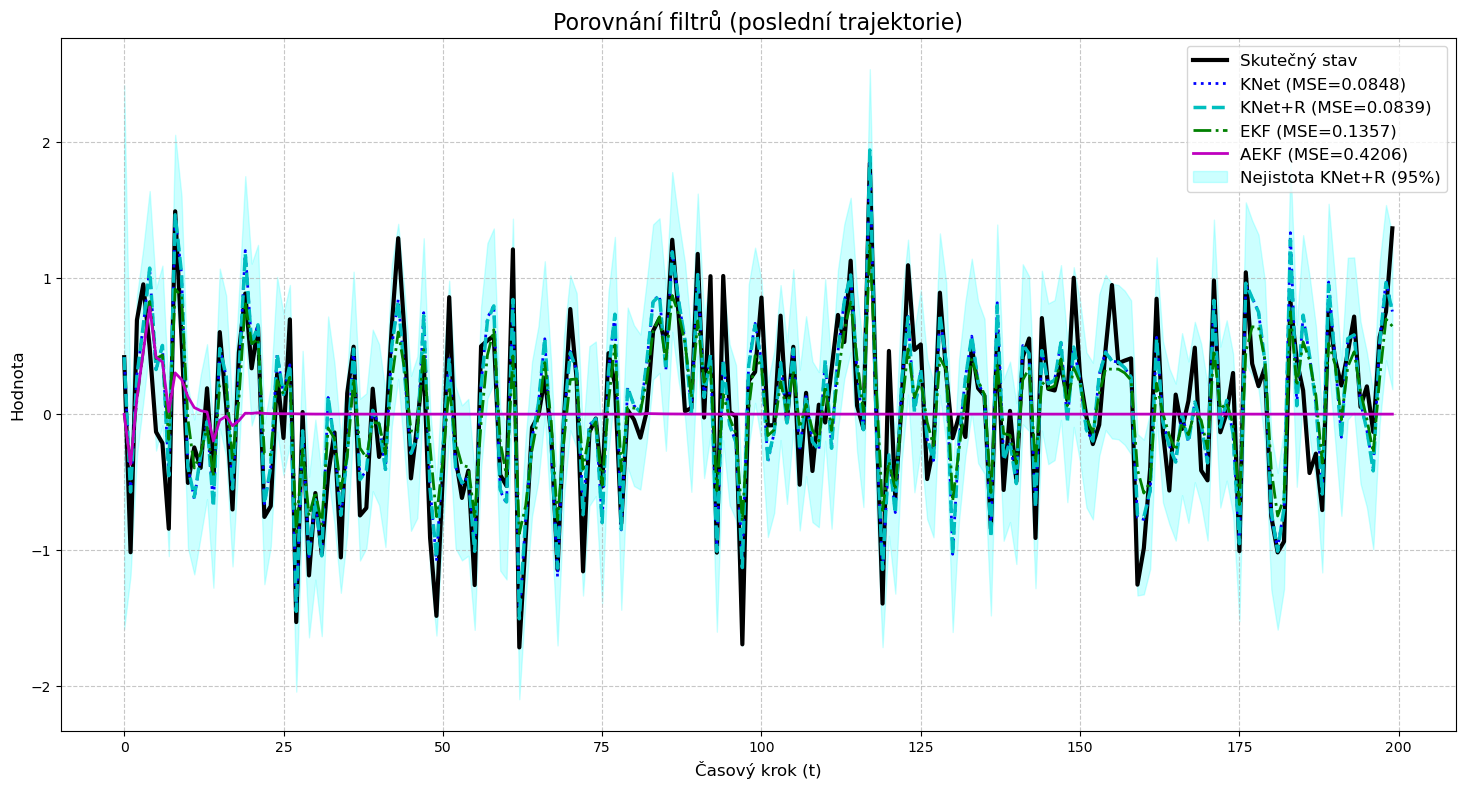

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2


def calculate_anees(x_true, x_hat, P_hat):
    """
    Vypočítá Average NEES (ANEES) pro JEDNU trajektorii.
    """
    seq_len, state_dim = x_true.shape
    nees_samples = torch.zeros(seq_len, device=x_true.device)

    for t in range(seq_len):
        error = x_true[t] - x_hat[t]
        P_t = P_hat[t]
            
        P_t_matrix = P_t.reshape(state_dim, state_dim)
        P_stable = P_t_matrix + torch.eye(state_dim, device=P_t_matrix.device) * 1e-9
        
        try:
            P_inv = torch.inverse(P_stable)
            nees_samples[t] = error.unsqueeze(0) @ P_inv @ error.unsqueeze(-1)
        except torch.linalg.LinAlgError:
            nees_samples[t] = float('nan')
            
    return torch.nanmean(nees_samples).item()

TEST_SEQ_LEN = 200
NUM_TEST_TRAJ = 100

print(f"Generuji {NUM_TEST_TRAJ} testovacích trajektorií...")
x_test, y_test = utils.generate_data(sys_true, num_trajectories=NUM_TEST_TRAJ, seq_len=TEST_SEQ_LEN)

state_knet.eval()
state_knet_R.eval()

all_mse_knet, all_mse_knet_R, all_mse_ekf, all_mse_aekf = [], [], [], []
all_anees_knet_R, all_anees_ekf, all_anees_aekf = [], [],[]

print(f"Vyhodnocuji na {NUM_TEST_TRAJ} testovacích trajektoriích...")

with torch.no_grad():
    for i in range(NUM_TEST_TRAJ):
        y_test_seq = y_test[i].to(device)
        x_true_seq = x_test[i].to(device)
        
        initial_state_gpu = x_true_seq[0, :].unsqueeze(0)
        state_knet.reset(batch_size=1, initial_state=initial_state_gpu)
        knet_predictions_x_gpu = []
        for t in range(1, TEST_SEQ_LEN):
            y_t = y_test_seq[t, :].unsqueeze(0)
            x_filtered_t = state_knet.step(y_t)
            knet_predictions_x_gpu.append(x_filtered_t.squeeze(0))
        
        x_hat_knet_run_gpu = torch.stack(knet_predictions_x_gpu, dim=0)
        x_hat_knet_full = torch.cat([initial_state_gpu, x_hat_knet_run_gpu], dim=0).cpu()

        state_knet_R.reset(batch_size=1, initial_state=initial_state_gpu)
        knet_R_predictions_x_gpu, knet_R_predictions_P_gpu = [], []
        for t in range(1, TEST_SEQ_LEN):
            y_t = y_test_seq[t, :].unsqueeze(0)
            x_filtered_t, P_filtered_t = state_knet_R.step(y_t)
            knet_R_predictions_x_gpu.append(x_filtered_t.squeeze(0))
            knet_R_predictions_P_gpu.append(P_filtered_t.squeeze(0))
            
        x_hat_knet_R_run_gpu = torch.stack(knet_R_predictions_x_gpu, dim=0)
        P_hat_knet_R_run_gpu = torch.stack(knet_R_predictions_P_gpu, dim=0)
        
        x_hat_knet_R_full = torch.cat([initial_state_gpu, x_hat_knet_R_run_gpu], dim=0).cpu()
        P0_gpu = sys_model.P0.to(device)
        P_hat_knet_R_full = torch.cat([P0_gpu.unsqueeze(0), P_hat_knet_R_run_gpu], dim=0).cpu()
        
        ekf_instance = Filters.ExtendedKalmanFilter(sys_model)
        Ex0_run = x_true_seq[0, :].unsqueeze(-1)
        P0_run = sys_model.P0
        ekf_results = ekf_instance.process_sequence(
            y_test_seq, Ex0=Ex0_run, P0=P0_run
        )
        x_hat_ekf_full = ekf_results['x_filtered'].cpu()
        P_hat_ekf_full = ekf_results['P_filtered'].cpu()

        aekf_instance = Filters.AdaptiveExtendedKalmanFilter(sys_model, sys_model.Q, sys_model.R, alpha=0.01)
        Ex0_run = x_true_seq[0, :].unsqueeze(-1)
        P0_run = sys_model.P0
        aekf_results = aekf_instance.process_sequence(
            y_test_seq, Ex0=Ex0_run, P0=P0_run
        )
        x_hat_aekf_full = aekf_results['x_filtered'].cpu()
        P_hat_aekf_full = aekf_results['P_filtered'].cpu()

        x_true_seq_cpu = x_true_seq.cpu()
        state_dim = x_true_seq_cpu.shape[1]
        
        all_mse_knet.append(F.mse_loss(x_hat_knet_full, x_true_seq_cpu).item())
        all_mse_knet_R.append(F.mse_loss(x_hat_knet_R_full, x_true_seq_cpu).item())
        all_mse_ekf.append(F.mse_loss(x_hat_ekf_full, x_true_seq_cpu).item())
        all_mse_aekf.append(F.mse_loss(x_hat_aekf_full, x_true_seq_cpu).item())

        all_anees_knet_R.append(calculate_anees(x_true_seq_cpu, x_hat_knet_R_full, P_hat_knet_R_full))
        all_anees_ekf.append(calculate_anees(x_true_seq_cpu, x_hat_ekf_full, P_hat_ekf_full))
        all_anees_aekf.append(calculate_anees(x_true_seq_cpu, x_hat_aekf_full, P_hat_aekf_full))
        print(calculate_anees(x_true_seq_cpu, x_hat_aekf_full, P_hat_aekf_full))

avg_mse_knet = np.mean(all_mse_knet)
avg_mse_knet_R = np.mean(all_mse_knet_R)
avg_mse_ekf = np.mean(all_mse_ekf)
avg_mse_aekf = np.mean(all_mse_aekf)
avg_anees_knet_R = np.mean(all_anees_knet_R)
avg_anees_ekf = np.mean(all_anees_ekf)
avg_anees_aekf = np.mean(all_anees_aekf)

print("\n" + "="*50)
print(f"FINÁLNÍ VÝSLEDKY (průměr přes {NUM_TEST_TRAJ} běhů)")
print("="*50)
print("\n--- Průměrná MSE (přesnost) ---")
print(f"StateKalmanNet:          {avg_mse_knet:.4f}")
print(f"StateKalmanNetWithKnownR:{avg_mse_knet_R:.4f}")
print(f"EKF:                     {avg_mse_ekf:.4f}")
print(f"AEKF:                    {avg_mse_aekf:.4f}")
print("\n--- Průměrný ANEES (kredibilita/kalibrace) ---")
print(f"Očekávaná hodnota: {state_dim:.4f}")
print("---------------------------------------")
print(f"StateKalmanNetWithKnownR:{avg_anees_knet_R:.4f}")
print(f"EKF:                     {avg_anees_ekf:.4f}")
print(f"AEKF:                    {avg_anees_aekf:.4f}")
print("="*50)

plt.figure(figsize=(18, 9))
plt.title("Porovnání filtrů (poslední trajektorie)", fontsize=16)

x_true_plot = x_true_seq.cpu().numpy().squeeze() 

knet_mean_plot = x_hat_knet_full.numpy().squeeze()
knet_R_mean_plot = x_hat_knet_R_full.numpy().squeeze()
ekf_mean_plot = x_hat_ekf_full.numpy().squeeze()
aekf_mean_plot = x_hat_aekf_full.numpy().squeeze()
knet_R_std_plot = torch.sqrt(torch.diagonal(P_hat_knet_R_full, dim1=-2, dim2=-1)).numpy().squeeze()
time_steps = range(len(x_true_plot))

plt.plot(time_steps, x_true_plot, 'k-', linewidth=3, label="Skutečný stav")
plt.plot(time_steps, knet_mean_plot, 'b:', linewidth=2, label=f"KNet (MSE={all_mse_knet[-1]:.4f})")
plt.plot(time_steps, knet_R_mean_plot, 'c--', linewidth=2.5, label=f"KNet+R (MSE={all_mse_knet_R[-1]:.4f})")
plt.plot(time_steps, ekf_mean_plot, 'g-.', linewidth=2, label=f"EKF (MSE={all_mse_ekf[-1]:.4f})")
plt.plot(time_steps, aekf_mean_plot, 'm-', linewidth=2, label=f"AEKF (MSE={all_mse_aekf[-1]:.4f})")
plt.fill_between(time_steps, knet_R_mean_plot - 2 * knet_R_std_plot, knet_R_mean_plot + 2 * knet_R_std_plot, 
                 color='cyan', alpha=0.2, label='Nejistota KNet+R (95%)')

plt.xlabel("Časový krok (t)", fontsize=12)
plt.ylabel("Hodnota", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.show()